In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# note that missingno doesn't come with anaconda, so install it the first time you run this
!pip install missingno
import missingno
import math
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import chi2_contingency
from scipy.stats import chi2

First, read in the dataset.  Here, we use `read_csv()`, but there are also methods for reading from Excel, SQL or the clipboard: `read_excel()`, `read_sql()`, `read_clipboard()`

In [2]:
df = pd.read_csv('titanic/train.csv')
df_test = pd.read_csv('titanic/test.csv')
# let's print out how many entries there are in the dataset
print(len(df))

891


What are the fields here?  Let's have a look at the first 5 rows:

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Do these columns make sense?  Name, Sex, Age and Fare seem fairly obvious.  Survived is *probably* a boolean value indicating if the person survived - we should check the values match our assumption later.  Ticket probably refers to a ticket number. passengerId looks like it is just an internal index for the dataset - it seems like it is just a sequence. 


There are explicit definitions for the column types that are given to us from the Kaggle site.  Here are the less obvious ones:
* Pclass - Ticket class (SES proxy, 1st = Upper, 2nd = Middle, 3rd = Lower)
* SibSp - Number of siblings / spouses aboard the Titanic
   * Sibling - brother, sister, stepbrother, stepsister
   * Spouse - husband, wife
* Parch - Number of parents / children aboard the Titanic
   * Parent - mother, father
   * Child - daughter, son, stepdaughter, stepson
* Embarked - Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)
* Age - Fractional if less than 1. If the age is estimated, is it in the form of xx.5

Note: we are told that we need to predict who survived, so this tells us that *Survived* is our target variable.


Let's check the datatypes:

In [11]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Some notes here: `object` is generally a string, int64 is integer, so, discrete, and float64 is a continuous or real number.  This can be misleading, however, in pandas, because it will not automatically cast datetimes, and they will show up as strings.  You need to explicitly cast them.

Let's take a look at some quick descriptive stats, first, for the numerical values:

In [12]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


And then for the categorical values:

In [13]:
df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,G6,S
freq,1,577,7,4,644


/opt/homebrew/Caskroom/miniforge/base/envs/py3c/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/py3c/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/py3c/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to

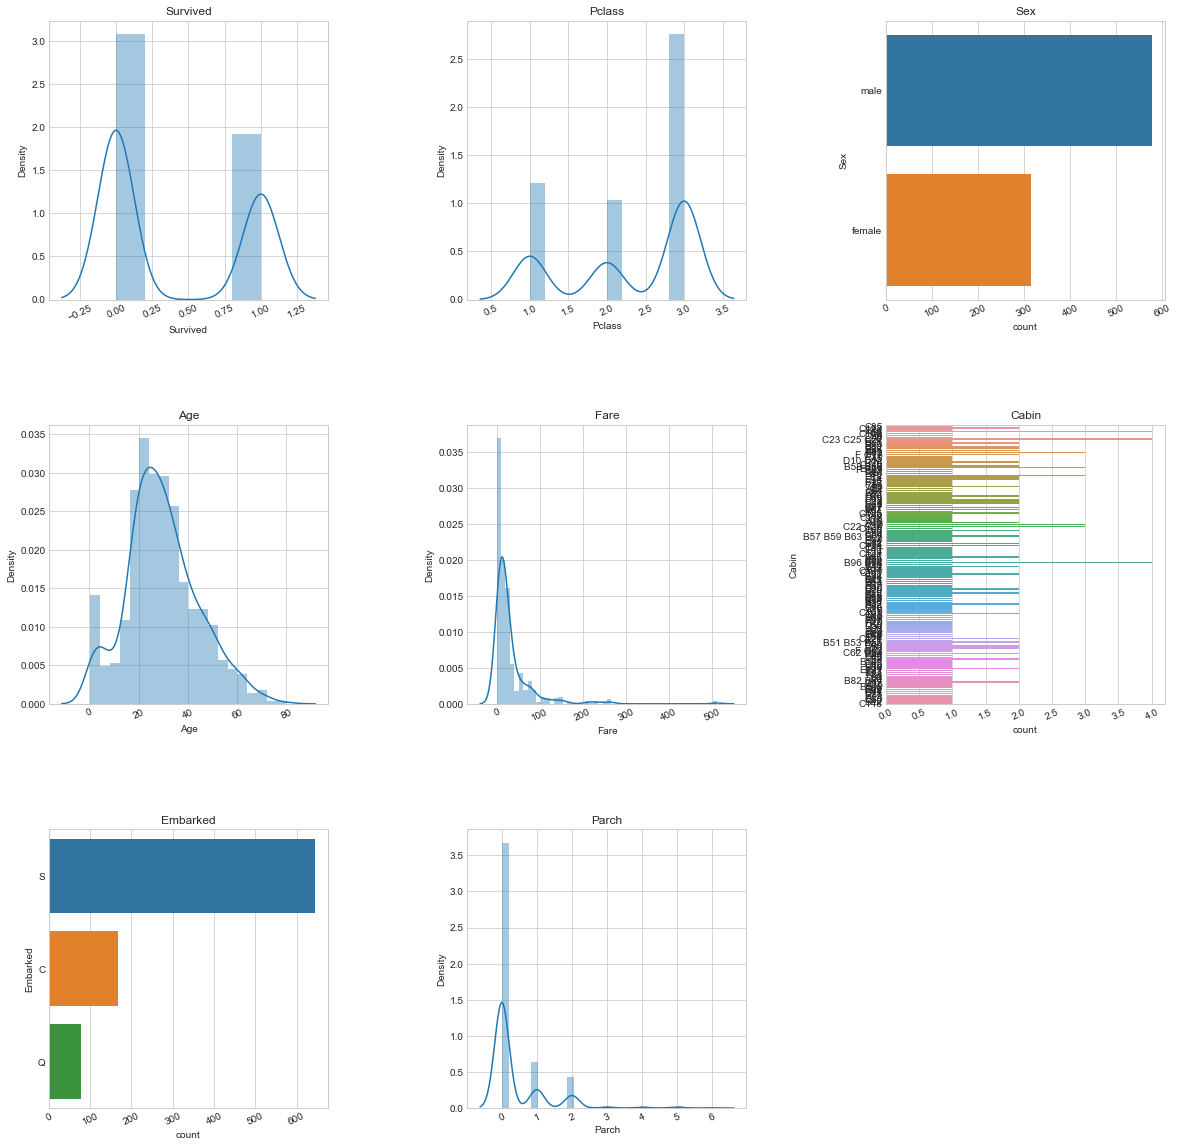

In [14]:
# Let’s plot the distribution of each feature
def plot_distribution(dataset, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == np.object:
            g = sns.countplot(y=column, data=dataset)
            substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            plt.xticks(rotation=25)
        else:
            g = sns.distplot(dataset[column])
            plt.xticks(rotation=25)
    
    
# what columns does it make sense to plot?
# Survived - we assumed this was bimodal, let's check
# Pclass - we're told it is 1, 2, or 3, but again, let's check

# don't want to plot
# PassengerId
# Name
# Ticket - this is probably unique per passenger, but again, we should double check

# Cabin - this is an interesting one, because it should *mostly* be unique, but there will be some people that share... let's plot anyway

cols_to_plot = ['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Cabin', 'Embarked', 'Parch']
plot_distribution(df[cols_to_plot], cols=3, width=20, height=20, hspace=0.45, wspace=0.5)

Oh no!  What happened?!  We have missing values it seems... 

<AxesSubplot:>

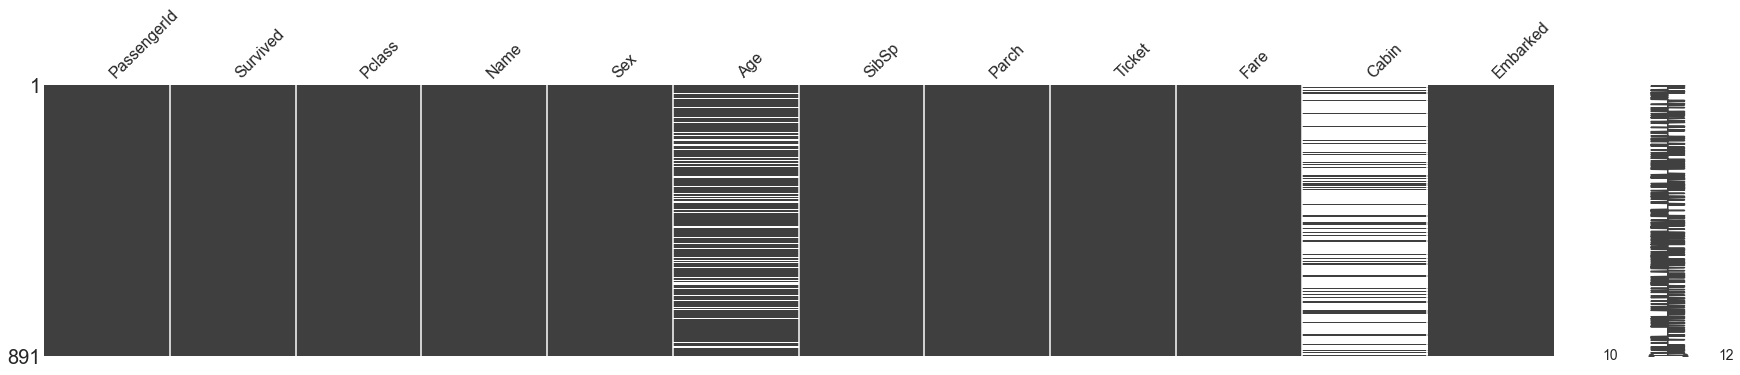

In [15]:
# missingnoany missing values are there in our dataset?
missingno.matrix(df, figsize = (30,5))

/opt/homebrew/Caskroom/miniforge/base/envs/py3c/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/py3c/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/py3c/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to

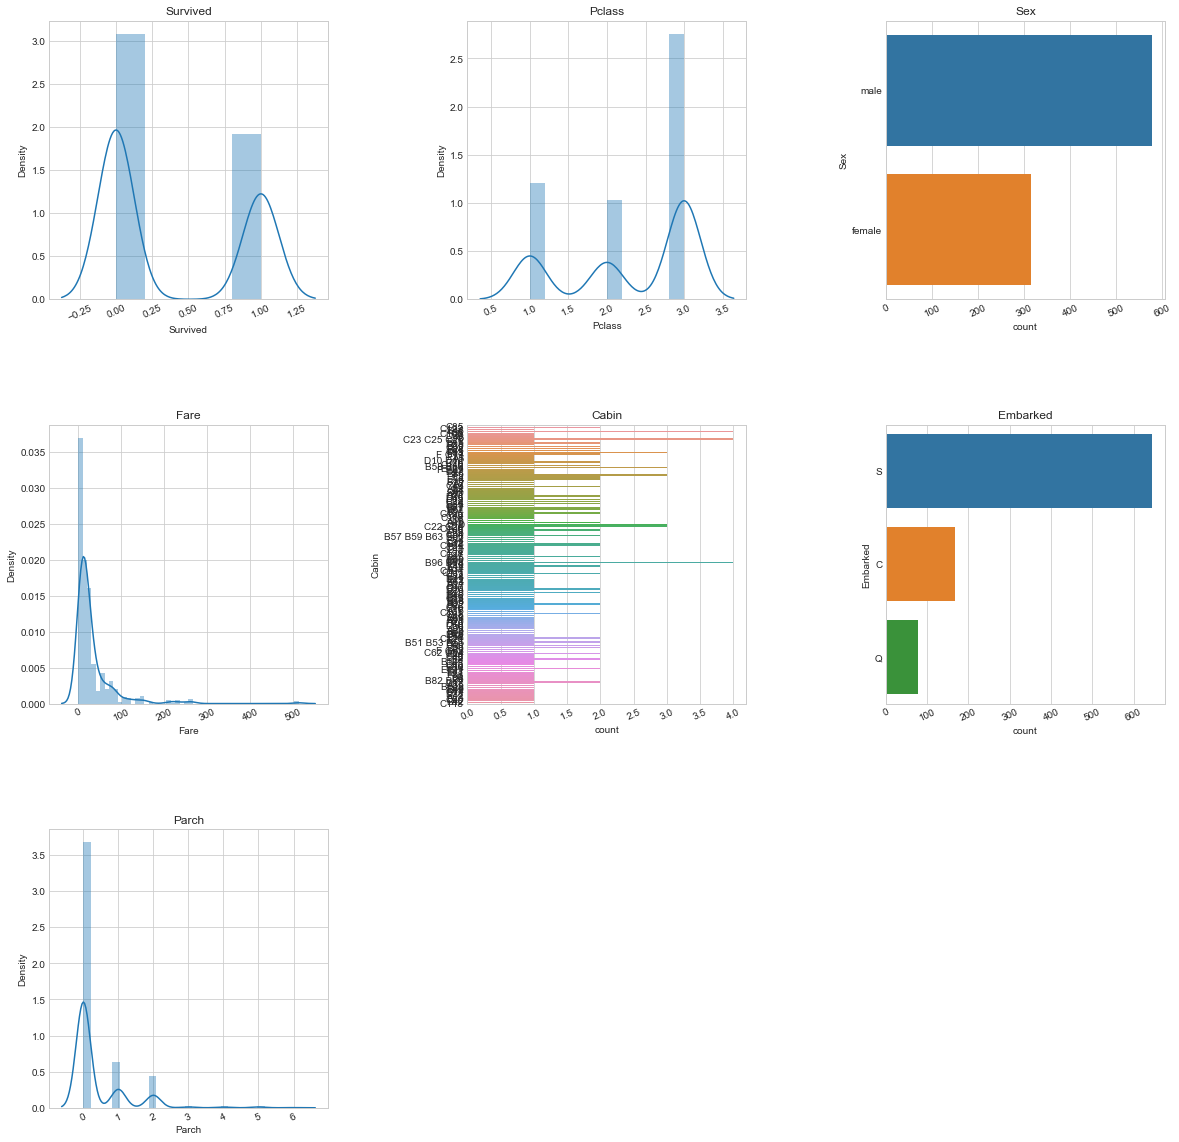

In [16]:
cols_to_plot = ['Survived', 'Pclass', 'Sex', 'Fare', 'Cabin', 'Embarked', 'Parch']
plot_distribution(df[cols_to_plot], cols=3, width=20, height=20, hspace=0.45, wspace=0.5)

Okay this gives us some useful information about our variables - we can see that Parch is discrete, which is expected.  We see the fares are all positive and the classes make sense. 

However, what do we do about the missing values - the age?! 

## Age analysis

We've all heard "women and children first", so presumably age is an important predictor.  The below plots seems to show some agreement with this hypothesis.  Which means that we probably do *not* want to throw out this variable!

/opt/homebrew/Caskroom/miniforge/base/envs/py3c/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/py3c/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/py3c/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please 

<AxesSubplot:xlabel='Age', ylabel='Density'>

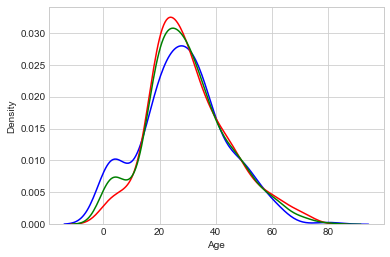

In [17]:
# let's take a look at the existing values... 
sns.distplot(df[(df.Age.notnull()) & (df.Survived == 1)]['Age'], hist=False, color='blue', label='survived')
sns.distplot(df[(df.Age.notnull()) & (df.Survived == 0)]['Age'], hist=False, color='red', label='died')
sns.distplot(df[(df.Age.notnull())]['Age'], hist=False, color='green', label='combined')


Let's also take a look at the age distribution for different passenger classes

/opt/homebrew/Caskroom/miniforge/base/envs/py3c/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/py3c/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/py3c/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please 

<AxesSubplot:xlabel='Age', ylabel='Density'>

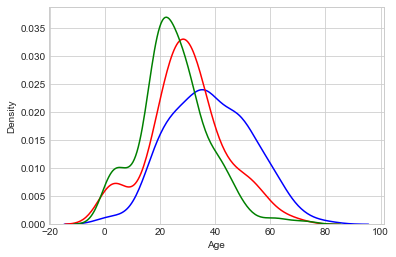

In [18]:
sns.distplot(df[(df.Age.notnull()) & (df.Pclass == 1)]['Age'], hist=False, color='blue', label='class 1')
sns.distplot(df[(df.Age.notnull()) & (df.Pclass == 2)]['Age'], hist=False, color='red', label='class 2')
sns.distplot(df[(df.Age.notnull()) & (df.Pclass == 3)]['Age'], hist=False, color='green', label='class 3')


Looks like the first classes passengers are in general slightly older - this makes sense if we consider that one is more likely to be in a higher socio-economic class the older they are.

What about sex and age?

/opt/homebrew/Caskroom/miniforge/base/envs/py3c/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/py3c/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Age', ylabel='Density'>

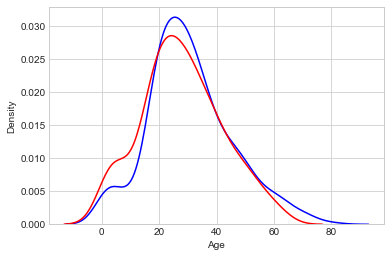

In [19]:
sns.distplot(df[(df.Age.notnull()) & (df.Sex == 'male')]['Age'], hist=False, color='blue', label='male')
sns.distplot(df[(df.Age.notnull()) & (df.Sex == 'female')]['Age'], hist=False, color='red', label='female')



What about survival rates by sex?  We also want to check how sex is related - yep that is confirmed too! 

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

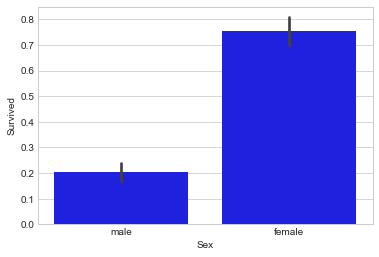

In [20]:
sns.barplot(x='Sex', y='Survived', data=df[(df.Age.notnull())], color='blue', label='survived')

Okay, so we now see that age is correlated with sex and class.  If we want to try and impute a value for age, we need to take this into account - we cannot just use the overall median/mean age.

As a very basic first pass, let's try using the median age per category.

In [21]:
df.Age = df.groupby(['Pclass', 'Sex'])['Age'].apply(lambda x: x.fillna(x.median()))

/opt/homebrew/Caskroom/miniforge/base/envs/py3c/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Age', ylabel='Density'>

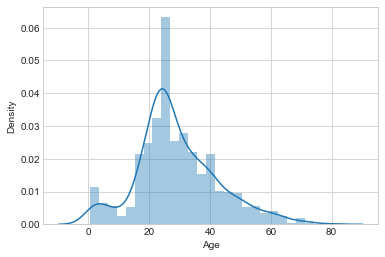

In [22]:
sns.distplot(df.Age)

## Cabin

There are also a large number of missing values for the cabin.  What about missing values for the cabin, how do we handle this?

In [23]:
print('number of unique cabins {0} and number of missing cabins {1} '.format(df.Cabin.nunique(), len(df[df.Cabin.isnull()])))

number of unique cabins 147 and number of missing cabins 687 


In [24]:
df[df.Cabin.notnull()].Cabin.head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

This is another important observation - there is a letter and a number.  This falls into the feature engineering space a bit.  We can get info from this... 

I encourage you to look for a picture of the titanic and the cabin layout.  You'll see that the letter here refers to the deck.  And higher decks were a higher class, with the bottom decks being the cheapest tickets.

Reading up on the Titanic (and looking at the data), people in the lower cabins were less likely to survive.  So this is again another variable that we do not want to lose or drop. 

However, since we know that the deck is related to the fare, we can try to figure out the cabin from the fare.

<AxesSubplot:xlabel='deck'>

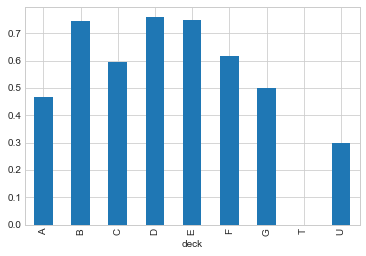

In [25]:
# let's get the deck
# We'll fill in U to say unknown for the missing ones
df['deck'] = df.Cabin.apply(lambda x: x[0] if pd.notnull(x) else 'U')
# we want to get this for the test set for later too
df_test['deck'] = df_test.Cabin.apply(lambda x: x[0] if pd.notnull(x) else 'U')



# then let's check our assumptions about the survival by deck
df[['deck', 'Survived']].groupby('deck')['Survived'].mean().plot(kind='bar')

Here, we can consider grouping together similar decks by the classes

I leave this as an exercise :) 

# Feature Engineering

## Titles

We can get the titles of the passengers - this might have some useful information about ages and socio-economic class.

In [26]:
df['name_list'] = df.Name.apply(lambda x: x.split(','))
# get the title from the Name
df['title'] = df.name_list.apply(lambda x: x[1].strip().split(' ')[0])
# get the surname
df['surname'] = df.name_list.apply(lambda x: x[0])
# first name
df['first_name'] = df.name_list.apply(lambda x: x[1].strip().split(' ')[1])

# do it for the test ds too
df_test['name_list'] = df_test.Name.apply(lambda x: x.split(','))
# get the title from the Name
df_test['title'] = df_test.name_list.apply(lambda x: x[1].strip().split(' ')[0])
# get the surname
df_test['surname'] = df_test.name_list.apply(lambda x: x[0])
# first name
df_test['first_name'] = df_test.name_list.apply(lambda x: x[1].strip().split(' ')[1])



print(df.title.value_counts())

Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Col.           2
Mlle.          2
Major.         2
the            1
Don.           1
Capt.          1
Ms.            1
Mme.           1
Sir.           1
Jonkheer.      1
Lady.          1
Name: title, dtype: int64


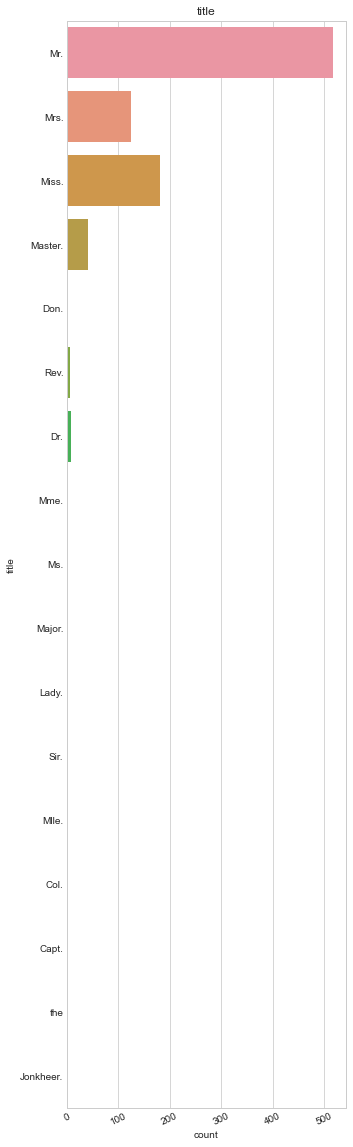

In [27]:
plot_distribution(df[['title']], cols=3, width=20, height=20, hspace=0.45, wspace=0.5)

Note that some of the titles have very few values - these are probably higher classes, but let's group them together as a first pass. 

In [35]:
df['title'] = np.where(df['title'].isin(['Mr.', 'Mrs.', 'Master.', 'Miss.']), df.title, 'Other')
print(df.title.value_counts())

Mr.        517
Miss.      181
Mrs.       124
Master.     40
Other       27
Name: title, dtype: int64


## Binning of Ages
This has the effect of reducing the bias that we introduced by including a median age.  It also allows us to better capture data from less common ages (older and younger people).

Note, we could do a similar thing for the fare too.

In [29]:
# let's do a basic one where we use 5 bins of ages:
df['age_bin'] = pd.cut(df.Age.astype(int), 5)
df_test['age_bin'] = pd.cut(df.Age.astype(int), 5)


print(df.age_bin.value_counts())

## let's do a basic one where we use 5 bins of ages:
df['fare_bin'] = pd.qcut(df.Fare, 5)
df_test['fare_bin'] = pd.qcut(df.Fare, 5)

# print (pd.cut(df.Age.astype(int), 5))

(16.0, 32.0]     495
(32.0, 48.0]     216
(-0.08, 16.0]    100
(48.0, 64.0]      69
(64.0, 80.0]      11
Name: age_bin, dtype: int64


## Family Sizes
The family size might also give us some important information - perhaps fathers are less likely to survive because they made sure their kids survived?  

Let's add this feature! 

<AxesSubplot:>

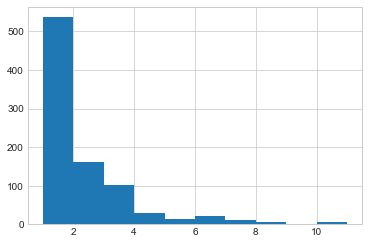

In [30]:
df['fam_size'] = df.SibSp + df.Parch + 1  # add 1 for themselves :) 
df_test['fam_size'] = df_test.SibSp + df_test.Parch + 1  # add 1 for themselves :) 


# then plot the distribution
df.fam_size.hist()

1    537
2    161
3    102
4     91
Name: fam_bin, dtype: int64


<AxesSubplot:xlabel='fam_bin'>

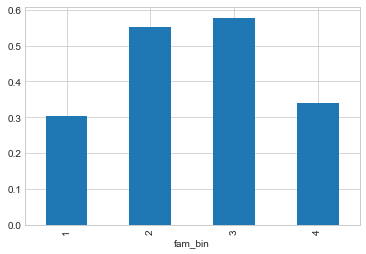

In [31]:
# We can bin this too, since there are some smaller bins at the top
#  then check the survival rates by family size
df['fam_bin'] = np.where(df.fam_size==1, 1, np.where(df.fam_size==2, 2, np.where(df.fam_size==3, 3, 4)))
print(df.fam_bin.value_counts())
df_test['fam_bin'] = np.where(df_test.fam_size==1, 1, np.where(df_test.fam_size==2, 2, np.where(df_test.fam_size==3, 3, 4)))



df[['fam_bin', 'Survived']].groupby('fam_bin')['Survived'].mean().plot(kind='bar')


Looks like smaller families have a better survival rate.  Be careful though, we can't say this about large families because there are far fewer values in this bin.

## one-hot encoding

As one last thing to do before we get to modelling, let's convert the strings to numerical values so that we can use more algorithms (like a Random Forest Classifier)

We'll do this for the following variables, which converts it into a numerical value:
* Embarked - 0, 1, 2
* Sex - this becomes 0 or 1
* title - 0,...,4
* deck - 0,....,X (after grouping)

Then, for the categorical values, we will need to do one-hot encoding.  This is because the values of 0, 1, 2 etc do not necessarily have any meaning for an algorithm.  Rather, we create a new column for each of these.  So, Sex becomes Sex_0 and Sex_1, and the value will be 1 in only one of those columns.  Similarly for title, there is a column for Mr, a column for Mrs, etc, instead of saying title belongs to group 0 or gorup 1. 


In [32]:
df = df[df.Embarked.notnull()].copy()
def encode_it_all(df):
    # print(len(df[df.Embarked.isnull()]))
    for feature in ['Embarked', 'Sex', 'title', 'deck', 'fare_bin', 'age_bin']:
        # print(df[feature])
        df[feature + '_encoded'] = LabelEncoder().fit_transform(df[feature])



    # one-hot encoding
    all_encodings = []
    encoded_features = []
    for feature in ['Embarked_encoded', 'Sex_encoded', 'title_encoded', 'deck_encoded', 'fare_bin_encoded', 'fam_bin', 'age_bin_encoded']:
        # print(feature)
        X = OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
        cols = [feature + '_' + str(i) for i in range(0, df[feature].nunique())]
        encoded_features += cols
        tmp_df = pd.DataFrame(X, columns=cols)
        tmp_df.index = df.index
        all_encodings.append(tmp_df)

    # then let's create a new df with all of these new variables
    return pd.concat([df, *all_encodings], axis=1)

df2 = encode_it_all(df)
df_test2 = encode_it_all(df_test)

In [36]:
df2[['PassengerId', 'age_bin_encoded_0', 'age_bin_encoded_1', 'age_bin_encoded_2', 'age_bin_encoded_3', 'age_bin_encoded_4']]

,PassengerId,age_bin_encoded_0,age_bin_encoded_1,age_bin_encoded_2,age_bin_encoded_3,age_bin_encoded_4
0,1,0.0,1.0,0.0,0.0,0.0
1,2,0.0,0.0,1.0,0.0,0.0
2,3,0.0,1.0,0.0,0.0,0.0
3,4,0.0,0.0,1.0,0.0,0.0
4,5,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...
886,887,0.0,1.0,0.0,0.0,0.0
887,888,0.0,1.0,0.0,0.0,0.0
888,889,0.0,1.0,0.0,0.0,0.0
889,890,0.0,1.0,0.0,0.0,0.0


# Modelling

A really basic classifier is the Random Forest Classifier.  This gets used really fequently - it is fast and can handle data in a pretty robust way.

In [33]:
rfc = RandomForestClassifier()
# standardise the data!! 
X = StandardScaler().fit_transform(df2[encoded_features])
y = df2.Survived.values

# split this up into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

rfc.fit(X_train, y_train)
# rfc.predict(df_test2[encoded_features])
print(rfc.score(X_test, y_test))

NameError: name 'encoded_features' is not defined

Okay, 78%... We have a baseline! I encourage you to look for other ways of engineering features and imputation, and trying other models

In [38]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'deck', 'name_list',
       'title', 'surname', 'first_name', 'age_bin', 'fare_bin', 'fam_size',
       'fam_bin', 'Embarked_encoded', 'Sex_encoded', 'title_encoded',
       'deck_encoded', 'fare_bin_encoded', 'age_bin_encoded'],
      dtype='object')

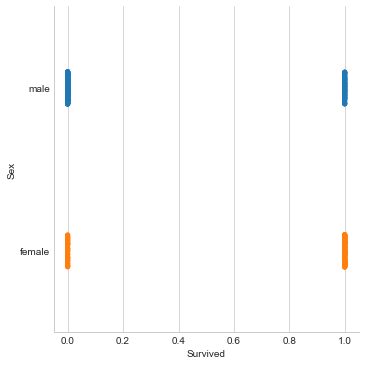

In [71]:
sns.catplot(data=df, x='Survived', y='Sex')

In [73]:
df.groupby(['Sex', 'Survived']).count()

PassengerId  Pclass  Name  Age  SibSp  Parch  Ticket  Fare  \
Sex    Survived                                                               
female 0                  81      81    81   81     81     81      81    81   
       1                 231     231   231  231    231    231     231   231   
male   0                 468     468   468  468    468    468     468   468   
       1                 109     109   109  109    109    109     109   109   

                 Cabin  Embarked  ...  fare_bin  fam_size  fam_bin  \
Sex    Survived                   ...                                
female 0             6        81  ...        81        81       81   
       1            89       231  ...       231       231      231   
male   0            62       468  ...       468       468      468   
       1            45       109  ...       109       109      109   

                 Embarked_encoded  Sex_encoded  title_encoded  deck_encoded  \
Sex    Survived                                                               
female 0                       81           81             81            81   
       1                      231          231            231           231   
male   0                      468          468            468           468   
       1                      109          109            109           109   

                 fare_bin_encoded  age_bin_encoded  sex_woe  
Sex    Survived                                              
female 0                       81               81       81  
       1                      231              231      231  
male   0                      468              468      468  
       1                      109              109      109  

[4 rows x 26 columns]

In [74]:
# calculating the weight of evidence for survival for the category Sex
male_event = len(df[(df.Survived == 0) & (df.Sex == 'male')]) / len(df[df.Survived == 0])
male_non_event = len(df[(df.Survived == 1) & (df.Sex == 'male')]) / len(df[(df.Survived == 1)])
woe_male = np.log(male_non_event/male_event)
print(woe_male)

female_event = len(df[(df.Survived == 0) & (df.Sex == 'female')]) / len(df[df.Survived == 0])
female_non_event = len(df[(df.Survived == 1) & (df.Sex == 'female')]) / len(df[(df.Survived == 1)])
woe_female = np.log(female_non_event/female_event)
print(woe_female)

df['sex_woe'] = np.where(df.Sex == 'male', woe_male, woe_female)

-0.9779675897891793
1.5271213797486785


In [22]:
cont = pd.crosstab(df.Sex, df.Pclass)
print(cont)

Pclass    1    2    3
Sex                  
female   94   76  144
male    122  108  347


In [23]:
stat, p, dof, expected = chi2_contingency(cont)
print(expected)

[[ 76.12121212  64.84399551 173.03479237]
 [139.87878788 119.15600449 317.96520763]]


In [43]:
chi2_tab = (cont - expected)**2/expected
print(chi2_tab)

Pclass         1         2         3
Sex                                 
female  4.199238  1.919321  4.871963
male    2.285200  1.044483  2.651294


In [45]:
print('computed chi2', chi2_tab.sum().sum())
print('chi2_contingency chi2', stat)

computed chi2 16.97149909551711
chi2_contingency chi2 16.971499095517114


In [50]:
# is it stat significant at 95% level?
critical_value = chi2.ppf(0.95, dof)
signif = abs(stat)>critical_value
print('chi2', stat)
if signif:
    print('Reject H0, dependent')
else:
    print('Cannot reject H0')

# Use the p-value instead
alpha = 1.0 - 0.95
print('p-value:', p)
if p <= alpha:
    print('Reject H0, dependent')
else:
    print('Cannot reject H0')

chi2 16.971499095517114
Reject H0, dependent
p-value: 0.00020638864348233114
Reject H0, dependent
